In [20]:

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image


In [12]:
from google.colab import drive
drive.mount("/content/drive")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# CHANGE this path if needed
IMG_DIR = "/content/drive/MyDrive/Data/images_train"

In [14]:
model = ResNet50(
    weights="imagenet",
    include_top=True
)

# Name of last convolutional layer (standard for ResNet50)
LAST_CONV_LAYER = "conv5_block3_out"


In [15]:
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ],
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [17]:
def overlay_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_177']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


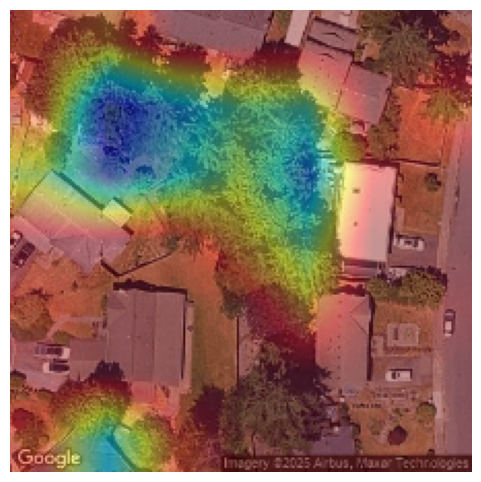

In [18]:
img_path = f"{IMG_DIR}/984000410.png"   # change ID

img_array = load_preprocess_image(img_path)
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    LAST_CONV_LAYER
)

overlay_gradcam(img_path, heatmap)


In [21]:
train_df = pd.read_csv("/content/drive/MyDrive/Data/train.csv")

In [22]:
price_sorted = train_df.sort_values("price").reset_index(drop=True)


In [23]:
low_price_samples = price_sorted.head(5)[["id", "price"]]
low_price_samples


,id,price
0,3421079032,75000
1,8658300340,80000
2,3028200080,81000
3,3883800011,82000
4,1523049188,84000


In [24]:
high_price_samples = price_sorted.tail(5)[["id", "price"]]
high_price_samples


,id,price
16204,1924059029,4668000
16205,1247600105,5110800
16206,9208900037,6885000
16207,9808700762,7062500
16208,6762700020,7700000


In [25]:
mid_index = len(price_sorted) // 2
avg_price_samples = price_sorted.iloc[mid_index-2:mid_index+3][["id", "price"]]
avg_price_samples


,id,price
8102,7853321090,450000
8103,926069132,450000
8104,3981200250,450000
8105,5039300305,450000
8106,217500135,450000


In [26]:
gradcam_ids = list(low_price_samples["id"][:2]) + \
              list(high_price_samples["id"][:2]) + \
              [avg_price_samples.iloc[2]["id"]]

print("Grad-CAM Property IDs:", gradcam_ids)


Grad-CAM Property IDs: [3421079032, 8658300340, 1924059029, 1247600105, np.int64(3981200250)]


Processing ID: 3421079032


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_177']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


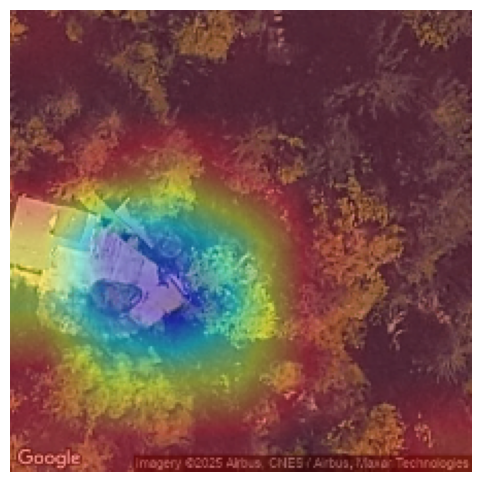

Processing ID: 8658300340


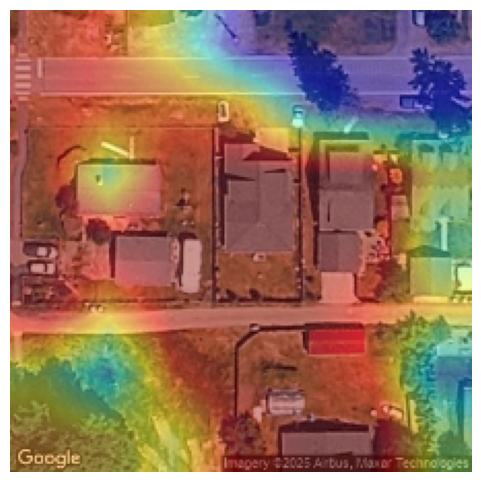

Processing ID: 1924059029


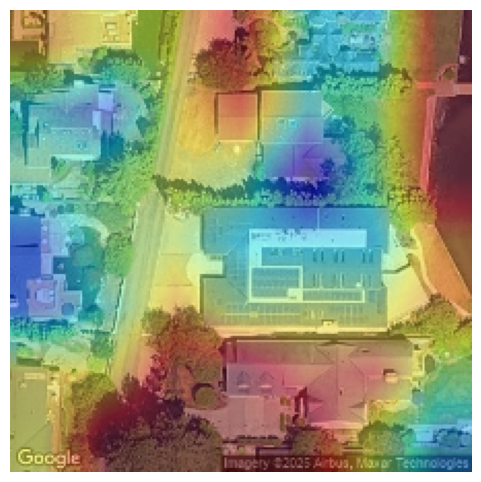

Processing ID: 1247600105


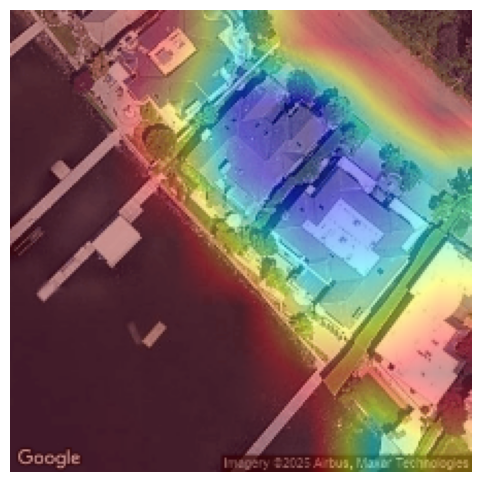

Processing ID: 3981200250


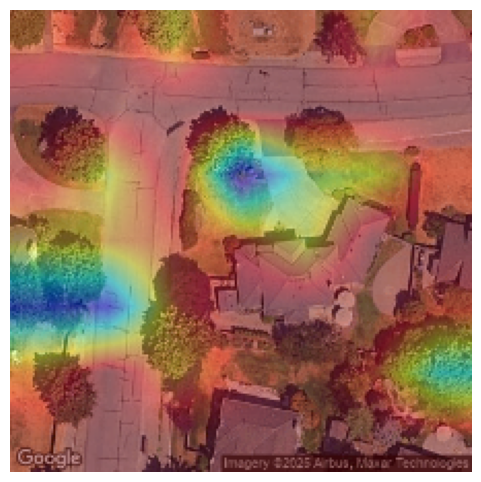

In [27]:
for pid in gradcam_ids:
    img_path = f"{IMG_DIR}/{pid}.png"
    print(f"Processing ID: {pid}")

    img_array = load_preprocess_image(img_path)
    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        LAST_CONV_LAYER
    )
    overlay_gradcam(img_path, heatmap)


Grad-CAM analysis was conducted on representative low-, mid-, and high-priced properties selected from the training distribution to ensure interpretability across the full price spectrum.